# Riconoscimento numeri laterali

Riconosce i numeri a lato delle auto da corsa contenuti in uno sticker quadrato bianco

## Download delle dipendenze

- `opencv-python` per manipolare ed eseguire operazioni sulle immagini
- `matplotlib` per visualizzare i risultati nel notebook
- `ipywidgets` per rendere interattivo il notebook
- `pytesseract` per riconoscere i numeri nelle immagini
- `ultralytics` per riconoscere le auto con yolo

In [11]:
%pip install opencv-python matplotlib ipywidgets pytesseract

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\michi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [12]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

image_path = "test_audi.png"

image_color = cv2.imread(image_path, cv2.IMREAD_COLOR)
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

## Conversione dell'immagine in B/W e threshold

Durante i test uno dei problemi principali era la trasformazione in bianco e nero dell'immagine.

Utilizzando semplicemente `cv2.cvtColor` per convertirla in bianco e nero, lasciava chiazze biancastre dove erano presenti colori molto accentuati (come il giallo)

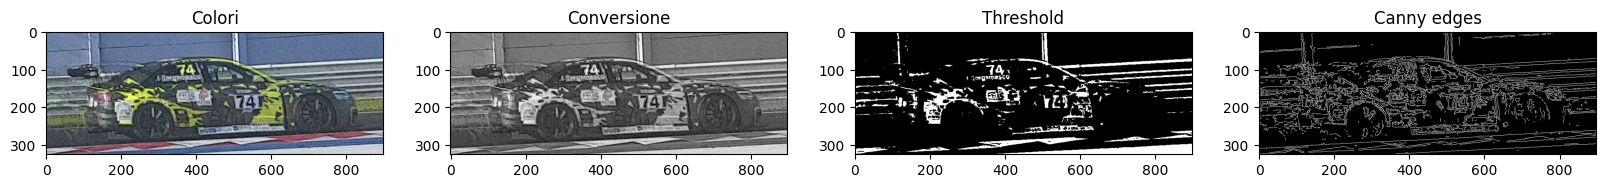

In [13]:



_, bin_thres = cv2.threshold(image_gray, 160, 255, cv2.THRESH_BINARY)

edges = cv2.Canny(image_gray,160,255)

fig, axes = plt.subplots(1, 4, figsize=(20, 20))
axes[0].imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
axes[0].set_title("Colori")

axes[1].imshow(image_gray, "gray")
axes[1].set_title("Conversione")

axes[2].imshow(bin_thres, "gray")
axes[2].set_title("Threshold")

axes[3].imshow(edges, "gray")
axes[3].set_title("Canny edges")
plt.show()

Siamo riusciti a risolvere creando una funzione ad hoc per la treshold basata su  [questo articolo](https://realpython.com/python-opencv-color-spaces/), che taglia tutti i colori e i valori non necessari, lasciando soltanto le parti che rientrano nel range (nel nostro caso i bianchi)

In [14]:
import numpy as np


def new_thres(h1, s1, v1, h2, s2, v2):
    hsv = cv2.cvtColor(image_color, cv2.COLOR_BGR2HSV)
    lower_white = np.array([h1, s1, v1])
    upper_white = np.array([h2, s2, v2])

    mask = cv2.inRange(hsv, lower_white, upper_white)
    
    plt.imshow(mask, cmap="gray")
    plt.show()

    return mask



In [15]:

from ipywidgets import interactive, IntSlider
from IPython.display import display

h1 = IntSlider(min=0, max=179, value=98)
s1 = IntSlider(min=0, max=255, value=0)
v1 = IntSlider(min=0, max=255, value=127)

h2 = IntSlider(min=0, max=179, value=155)
s2 = IntSlider(min=0, max=255, value=90)
v2 = IntSlider(min=0, max=255, value=255)

thres_viewer = interactive(new_thres, h1 = h1, s1 = s1, v1 = v1, h2 = h2, s2 = s2, v2 = v2)
display(thres_viewer)



interactive(children=(IntSlider(value=98, description='h1', max=179), IntSlider(value=0, description='s1', max…

In [16]:
thres = thres_viewer.result

## Riconoscimento del blocco con il numero

A primo impatto il risultato della funzione custom può sembrare peggiore, ma applicando poi il riconoscimento dei contorni possiamo notare che si riesce a trovare più facilmente il quadrato con il numero


In [17]:

"""
Calcola i contorni nell'immagine e li approssima secondo un epsilon fissato
Restituisce un array con tutti i pezzi di immagine che potrebbero contenere il box con il numero
"""
def calc_epsilon(image, e = 0.07110000000000001):
    contours, _ = cv2.findContours( image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    converted = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    cv2.drawContours(converted, contours, -1, (255, 0, 0), 3)

    angles = []
    approxed = []

    for contour in contours:
        epsilon = e * cv2.arcLength(contour, False)
        approx = cv2.approxPolyDP(contour, epsilon, True)

        x, y, w, h = cv2.boundingRect(approx)

        areaRect = cv2.minAreaRect(approx)
        angle = areaRect[2]

        if w > 20 and w < 100 and h > 20 and h < 60 and len(approx) == 3 and angle < 10:
            cv2.drawContours(converted, [approx], -1, (0, 255, 0), 3)
            cut = image[y:y+h, x:x+w]

            approxed.append(cut)
            angles.append(- angle)
                

    plt.imshow(converted)
    plt.show()
    return approxed, angles

In [18]:
from ipywidgets import FloatSlider, fixed
contours_viewer = interactive(calc_epsilon,image = fixed(thres), e=FloatSlider(min=0.0001, max=0.1, value=0.07110000000000001, step=0.001))

display(contours_viewer)

interactive(children=(FloatSlider(value=0.07110000000000001, description='e', max=0.1, min=0.0001, step=0.001)…

Per correttezza si può provare a giocare con l'altra immagine, ma i risultati sono pessimi.

Questo perché utilizzando la funzione di base `cv2.threshold`si tende cancellare il piccolo spazio bianco che c'è tra il numero e la macchina fondendoli tra loro e rendendo impossibile il riconoscimento di un box

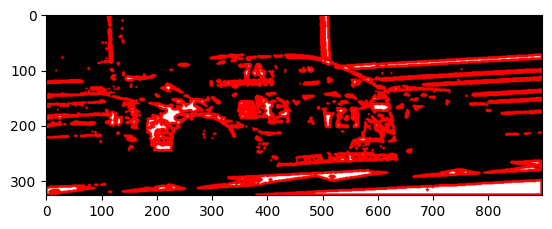

([], [])

In [19]:
calc_epsilon(image=bin_thres)

# Tentativi di miglioramento dell'immagine

Ora non resta che scorrere la lista delle immagini e riconoscere il numero

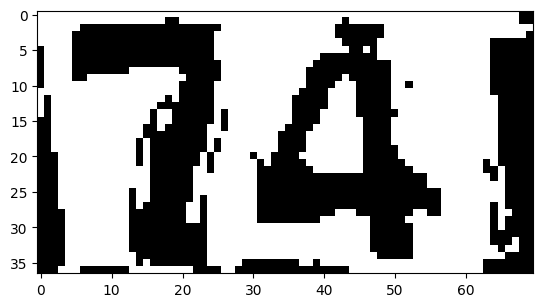

74


In [20]:
import pytesseract

# oem 3 indica di utilizzare il motore di default
# psm 7 indica che il testo che stiamo leggendo è composto da una sola riga
# tessedit_char_whitelist indica la lisa dei caratteri ammessi
custom_oem_psm_config = r'--oem 3 --psm 7 -c tessedit_char_whitelist=0123456789 --tessdata-dir C:\\Users\\michi\\Desktop\\riconoscimento_numeri\\models\\'

boxes, angles = contours_viewer.result
for box in boxes:
    plt.imshow(box, "gray")
    plt.show()
    

    text = pytesseract.image_to_string(box, config=custom_oem_psm_config)
    print(text.strip())

La bassissima risoluzione dell'immagine, che porta con se numerosi artefatti grafici, in molti casi porta a non riconoscere il numero (stranamente in questo caso no).

Quindi per sicurezza cerco di sistemare un po'

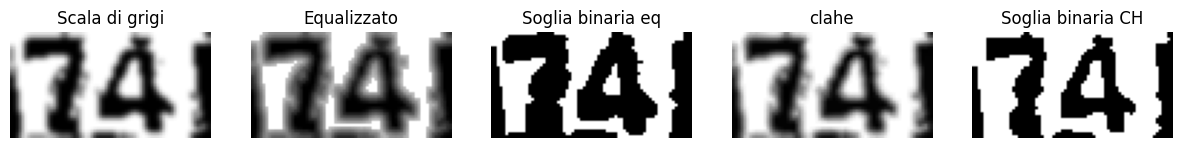

In [ ]:
gray = boxes[0]
# Applicare un filtro Gaussiano per ridurre il rumore
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Equalizzazione dell'istogramma per migliorare il contrasto
equalized = cv2.equalizeHist(blurred)

# Equalizzazione adattiva dell'istogramma
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(blurred)  # Miglioramento del contrasto

# Applicare la soglia binaria di Otsu
_, thresholded = cv2.threshold(equalized, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, enh_thres = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


# Mostrare i risultati intermedi
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title("Scala di grigi")

axes[1].imshow(equalized, cmap='gray')
axes[1].set_title("Equalizzato")

axes[2].imshow(thresholded, cmap='gray')
axes[2].set_title("Soglia binaria eq")

axes[3].imshow(enhanced, cmap='gray')
axes[3].set_title("clahe")

axes[4].imshow(enh_thres, cmap='gray')
axes[4].set_title("Soglia binaria CH")

for ax in axes:
    ax.axis("off")

plt.show()

Decido di utilizzare la soglia binaria ottenuta tramite l'equalizzazione adattiva dell'istogramma (CLAHE), questo perché ho notato che tesseract sembra funzionare meglio con i numeri più sottili.

Ora non resta che pulire l'immagine dalle macchie che non fanno parte del numero

Found  5 contours


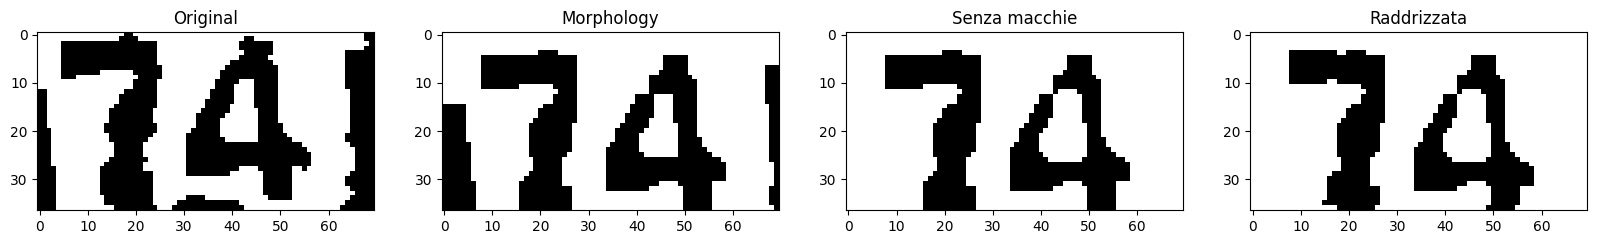

numero riconosciuto: 74


In [22]:
kernel = np.ones((2,2), np.uint8)

# Applicare una dilatazione e una erosione per rimuovere piccoli artefatti
dilated = cv2.morphologyEx(enh_thres, cv2.MORPH_CLOSE, kernel, iterations=3)

# Creare una copia bianco su nero
copy = cv2.bitwise_not(dilated)

# Trovare tutti i contorni dell'immagine e rimuovere quelli più piccoli (i numeri saranno le macchie più grandi)
contours, _ = cv2.findContours(copy, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
print("Found ", len(contours), "contours")

for c in contours:
    area = cv2.contourArea(c)
    x, y, w, h = cv2.boundingRect(c)

    if area < 200:
        cv2.drawContours(copy, [c], 0, 0, -1)


# Ruotare l'immagine per raddrizzare i numeri, l'angolo di rotazione viene individuato quando vengono riconosciuti i box
(height, width) = copy.shape[:2]
center = (width // 2, height // 2)
rotation_mat = cv2.getRotationMatrix2D(center, angles[0], 1)
result = cv2.warpAffine(copy, rotation_mat, copy.shape[1::-1], flags=cv2.INTER_NEAREST, borderValue=(0,0,0))

# Fare tornare l'immagine da bianco su nero a nero su bianco
result = cv2.bitwise_not(result)

# Mostrare i risultati intermedi
fig, axes = plt.subplots(1, 4, figsize=(20, 20))
axes[0].imshow(enh_thres, cmap='gray')
axes[0].set_title("Original")

axes[1].imshow(dilated, cmap='gray')
axes[1].set_title("Morphology")

axes[2].imshow(cv2.bitwise_not(copy), "gray")
axes[2].set_title("Senza macchie")

axes[3].imshow(result, "gray")
axes[3].set_title("Raddrizzata")
plt.show()


text = pytesseract.image_to_string(result, config=custom_oem_psm_config)
print("numero riconosciuto:",text.strip())

Per finire, posso provare ad aumentare la dimensione dell'immagine, così da avere dei contorni meno definiti e una risoluzione più alta, in alcune situazioni funziona e in altre no, non ho capito ancora come avere un risultato certo.

Sotto ho fatto i test con i vari metodi di interpolazione, ma sembrano avere tutti la stessa dimensione

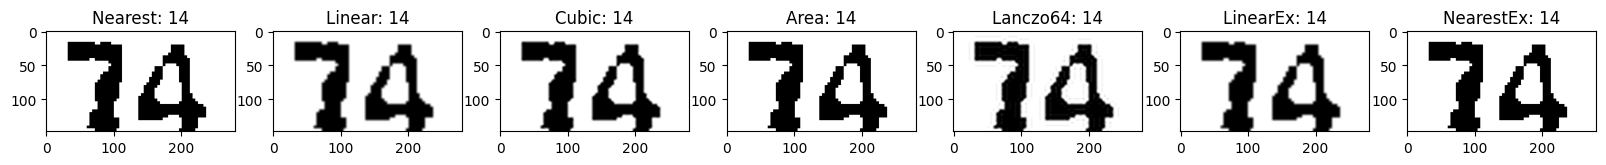

In [ ]:
interpolations = [
    "Nearest",
    "Linear",
    "Cubic",
    "Area",
    "Lanczo64",
    "LinearEx",
    "NearestEx"

]

scale_amount = 4

fig, axes = plt.subplots(1, len(interpolations), figsize=(20, 20))
for i, inter in enumerate(interpolations):
    scaled = cv2.resize(result, None, fx=scale_amount, fy=scale_amount, interpolation=i)
    recognized_text = pytesseract.image_to_string(scaled, config=custom_oem_psm_config)
    axes[i].imshow(scaled, "gray")
    axes[i].set_title(f"{inter}: {recognized_text.strip()}")

plt.show()